In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

data = pd.read_csv('firstsemester/BostonHousing.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [31]:
'''
We're trying to predict the median value (MEDV) of owner-occupied homes (in $1000s) in Boston suburbs based on various features such as crime rate, number of rooms, accessibility to highways, etc. Earlier, we saw how to do this with regression, which is far more rudimentary. Now we'll implement a simple neural network to perform the same task. I'm expecting better performance from this, given the complexity of neural networks.
'''

"\nWe're trying to predict the median value (MEDV) of owner-occupied homes (in $1000s) in Boston suburbs based on various features such as crime rate, number of rooms, accessibility to highways, etc. Earlier, we saw how to do this with regression, which is far more rudimentary. Now we'll implement a simple neural network to perform the same task. I'm expecting better performance from this, given the complexity of neural networks.\n"

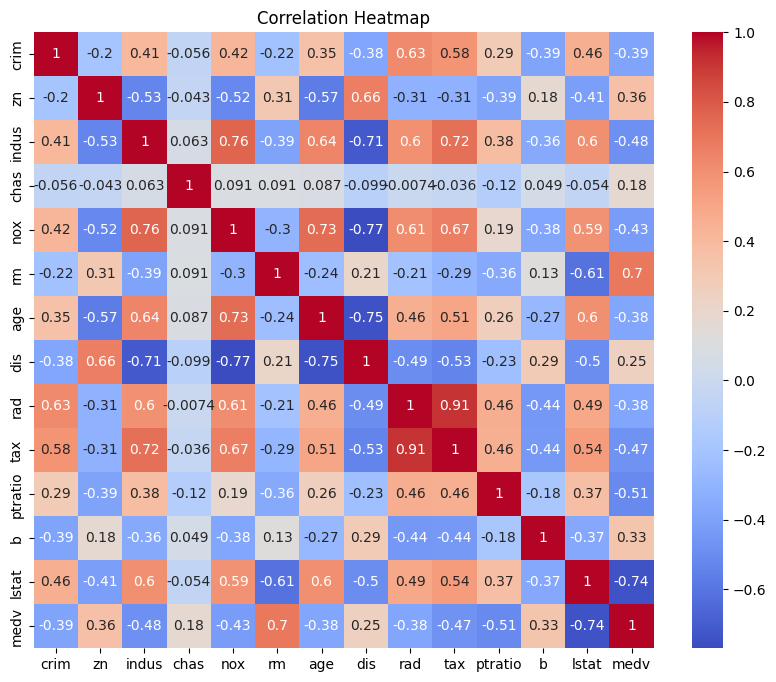

In [32]:
import seaborn as sns
# heatmap of corrs
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [33]:
# Intelligent feature selection based on correlation threshold
correlations = data.corr()['medv'].abs().sort_values(ascending=False)
print("Feature correlations with MEDV:")
print(correlations)

# Set intelligent threshold - include features with correlation > 0.4 (excluding medv itself obvi)
threshold = 0.3
selected_features = correlations[correlations > threshold].index.tolist()
selected_features.remove('medv')  
print(f"\nSelected features (|correlation| > {threshold}): {selected_features}")

features = data[selected_features].values 
target = data['medv'].values

print(f"\nUsing {len(selected_features)} features: {selected_features}")

Feature correlations with MEDV:
medv       1.000000
lstat      0.737663
rm         0.695360
ptratio    0.507787
indus      0.483725
tax        0.468536
nox        0.427321
crim       0.388305
rad        0.381626
age        0.376955
zn         0.360445
b          0.333461
dis        0.249929
chas       0.175260
Name: medv, dtype: float64

Selected features (|correlation| > 0.3): ['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'crim', 'rad', 'age', 'zn', 'b']

Using 11 features: ['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'crim', 'rad', 'age', 'zn', 'b']


In [47]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Split data into train/validation/test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

Training set: 303 samples
Validation set: 101 samples
Test set: 102 samples


In [48]:
class ImprovedNeuralNet(nn.Module):
    def __init__(self, input_size, dropout_rate=0.25):
        super(ImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.ln1 = nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.ln2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.ln3 = nn.LayerNorm(16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        # Experimental: Both BatchNorm + LayerNorm + dropout (might be overkill for small dataset!)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.ln1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.ln2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.ln3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc4(out)
        return out

torch.manual_seed(42)
input_size = len(selected_features)
model = ImprovedNeuralNet(input_size=input_size, dropout_rate=0.20)
print(f"Model architecture with {input_size} input features:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


Model architecture with 11 input features:
ImprovedNeuralNet(
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln3): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 3841


Epoch [50/2500], Train Loss: 558.1337, Val Loss: 545.4990, LR: 0.001000
Epoch [100/2500], Train Loss: 517.2968, Val Loss: 507.3785, LR: 0.001000
Epoch [150/2500], Train Loss: 483.9333, Val Loss: 473.4227, LR: 0.001000
Epoch [200/2500], Train Loss: 442.9474, Val Loss: 432.8671, LR: 0.001000
Epoch [250/2500], Train Loss: 393.6273, Val Loss: 385.4137, LR: 0.001000
Epoch [300/2500], Train Loss: 353.5291, Val Loss: 339.2128, LR: 0.001000
Epoch [350/2500], Train Loss: 308.7768, Val Loss: 293.4868, LR: 0.001000
Epoch [400/2500], Train Loss: 266.9344, Val Loss: 248.6178, LR: 0.001000
Epoch [450/2500], Train Loss: 232.4755, Val Loss: 210.4945, LR: 0.001000
Epoch [500/2500], Train Loss: 192.0326, Val Loss: 177.4863, LR: 0.001000
Epoch [550/2500], Train Loss: 168.8458, Val Loss: 150.2795, LR: 0.001000
Epoch [600/2500], Train Loss: 145.9494, Val Loss: 128.4404, LR: 0.001000
Epoch [650/2500], Train Loss: 131.9332, Val Loss: 110.7736, LR: 0.001000
Epoch [700/2500], Train Loss: 123.6814, Val Loss: 95

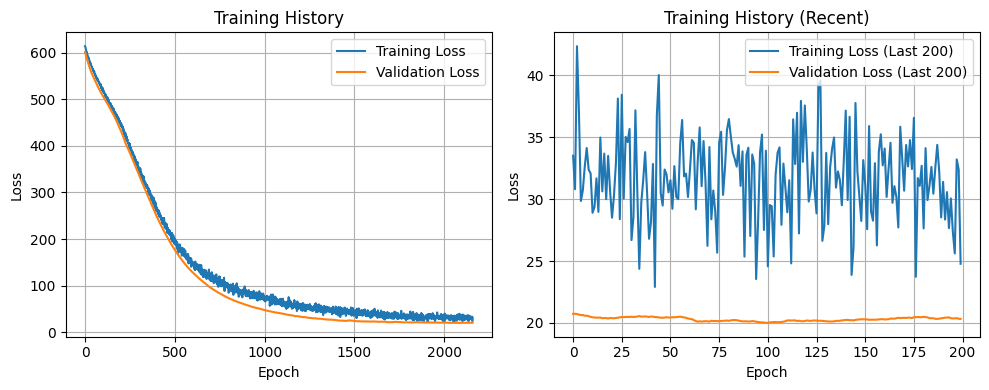

In [49]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

# Early stopping parameters
best_val_loss = float('inf')
patience = 100
patience_counter = 0
best_model_state = None

# Training history
train_losses = []
val_losses = []

max_epochs = 2500
for epoch in range(max_epochs):
    # Training phase
    model.train()
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{max_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f'ran out of patience at {epoch+1}')
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'Restored best model with validation loss: {best_val_loss:.4f}')

# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses[-200:], label='Training Loss (Last 200)')
plt.plot(val_losses[-200:], label='Validation Loss (Last 200)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History (Recent)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE: 13.9535
Test RMSE: 3.7354
Test MAE: 2.2870
Test R² Score: 0.8097
Mean Absolute Percentage Error: 10.88%


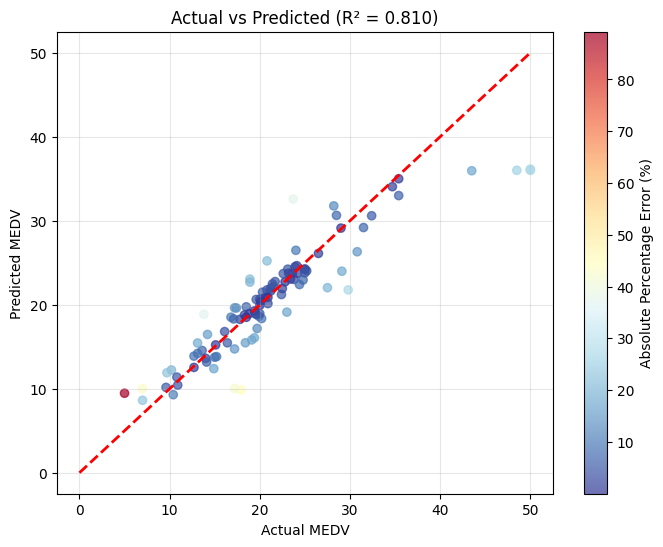

In [55]:
model.eval()
with torch.no_grad():
    # Test set predictions
    test_predicted = model(X_test_tensor)
    test_mse = criterion(test_predicted, y_test_tensor)
    
    # Convert to numpy for sklearn metrics
    test_pred_np = test_predicted.numpy().flatten()
    test_actual_np = y_test.flatten()
    test_mae = mean_absolute_error(test_actual_np, test_pred_np)
    test_r2 = r2_score(test_actual_np, test_pred_np)
    test_rmse = np.sqrt(test_mse.item())
    
    print(f'Test MSE: {test_mse.item():.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test R² Score: {test_r2:.4f}')
    print(f'Mean Absolute Percentage Error: {np.mean(np.abs((test_actual_np - test_pred_np) / test_actual_np)) * 100:.2f}%')

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Actual vs Predicted scatter plot
percent_diff = np.abs((test_actual_np - test_pred_np) / test_actual_np) * 100
scatter = axes.scatter(test_actual_np, test_pred_np, c=percent_diff, cmap='RdYlBu_r', alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes)
cbar.set_label('Absolute Percentage Error (%)')
axes.plot([0, 50], [0, 50], color='red', linestyle='--', linewidth=2)
axes.set_xlabel('Actual MEDV')
axes.set_ylabel('Predicted MEDV')
axes.set_title(f'Actual vs Predicted (R² = {test_r2:.3f})')
axes.grid(True, alpha=0.3)

plt.show()

In [57]:
"""
OLD MODEL: Test MSE Loss: 34.2420
NEW MODEL: Test MSE Loss: 16.0514 - Dropout, Validation, More Params, Scheduled Rates, Early Stopping
MODEL w/ LayerNorm: 11.5083 - Normalizing each layer, can't go wrong
MODEL w/ LayerNorm + BatchNorm: 13.9535 - batchnorm is preferred for larger datasets and deeper learning tasks
"""

"\nOLD MODEL: Test MSE Loss: 34.2420\nNEW MODEL: Test MSE Loss: 16.0514 - Dropout, Validation, More Params, Scheduled Rates, Early Stopping\nMODEL w/ LayerNorm: 11.5083 - Normalizing each layer, can't go wrong\nMODEL w/ LayerNorm + BatchNorm: 13.9535 - batchnorm is preferred for larger datasets and deeper learning tasks\n"